In [1]:
import g4f
import re
import requests
import pandas as pd
from pynterface import Ellipsis, smooth_print, Color
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np

PAGE_COUNT = 49
SEARCH_TERM = "genetically modified organisms effects on the world"
GET_SOUP = lambda url: BeautifulSoup(requests.get(url).text, "html.parser")
PROGRESS_FREQUENCY = 8

PROMPT = "Analyze the text to determine the effects of genetically modified organisms on the environment, the economy, and human health. " \
         "Your output should be in the following format: \"environment: <response>, economy: <response>, health: <response>\","\
         "where <response> can be 'G' for good, 'B' for bad, 'N' for neutral, or 'I' for not enough information."
ERROR_PROMPT = "Unable to fetch the response, Please try again."

Web scrape and obtain the abstracts for analysis, saved in a file.

In [ ]:
""" This part obtains the article id's to parse through, given a search term """

# in case of errors near the end
try:        
    with Ellipsis(message="Getting Article ID's"):

        article_ids = []
        search_url = f"https://pubmed.ncbi.nlm.nih.gov/?term={SEARCH_TERM.replace(' ', '%20')}&page="

        for page in range(1, PAGE_COUNT):
            soup = GET_SOUP(f"{search_url}{page}")
            for link in soup.find_all("a", {"class": "docsum-title"}):
                article_ids.append(link.attrs["data-article-id"])
        
except Exception as e: 
    print(e)        

""" This part obtainas abstracts from the articles """

with Ellipsis(message="Getting Abstracts") as loader:

    abstracts = []
    article_url = "https://pubmed.ncbi.nlm.nih.gov/"

    for index, id in enumerate(article_ids, start=1):
        soup = GET_SOUP(f"{article_url}{id}")
        if index % PROGRESS_FREQUENCY == 0:
            loader.print_above(f"{Color.BLUE}{index} {Color.RESET_COLOR}abstracts read.")
        try: 
            abstract = soup.find("div", {"class": "abstract-content"}).text
            abstract = abstract.strip().replace("\n", ' ')      # remove trailing and sub spaces for newlines between
            abstracts.append(abstract+"\n") 
        except:
            loader.print_above(f"{Color.RED}ERROR: {Color.RESET_COLOR}Article with ID {Color.BLUE}{id} {Color.RESET_COLOR}has no abstract.")

with open("abstracts.txt", "w") as f:

    # write to file
    f.writelines(abstracts)
    smooth_print("Successfully saved abstracts.")

Obtain the AI analysis of the abstracts.

In [2]:
def analyze_abstract(abstract):

    response = ERROR_PROMPT

    import nest_asyncio
    nest_asyncio.apply()

    # filter bad responses
    while ERROR_PROMPT in response:
        response = g4f.ChatCompletion.create(
            model=g4f.models.gpt_4,
            messages=[{"role": "user", "content": abstract+"\n"+PROMPT}],
            provider=g4f.Provider.DeepAi
        )

    response = response.lower()
        
    # get information
    output = {"environment": None, "economy": None, "health": None}
    for aspect in output:
        try:
            output[aspect] = re.search(fr"{aspect}: [a-z]", response).group().split()[1]
        except:
            continue
    
    return output

with open("abstracts.txt", "r") as f:
    abstracts = f.readlines()

data = {
    "environment": [],
    "economy": [],
    "health": [],
}

START_AT = 180

# analyze each abstract using the AI
try:
    with Ellipsis("Analyzing") as loader:
        for index, abstract in enumerate(abstracts, start=1):
            if index < START_AT:
                continue
            if not index % 5:
                loader.print_above(f"{index} articles analyzed.")
            response = analyze_abstract(abstract)
            for topic, effect in response.items():
                data[topic].append(effect)
finally:
    print(f"Done on the {index}th article.")
    current = pd.read_csv("data.csv")
    added = pd.DataFrame(data)
    pd.concat([current, added], ignore_index=True).to_csv("data.csv", index=False)

90 articles analyzed.
95 articles analyzed.                                                      
100 articles analyzed.                                           
105 articles analyzed.                                            
110 articles analyzed.                                                          
115 articles analyzed.                                                
120 articles analyzed.                                                    
125 articles analyzed.                                                                    
130 articles analyzed.                                              
135 articles analyzed.                                                                    
140 articles analyzed.                                                 
145 articles analyzed.                                                           
150 articles analyzed.                                                          
155 articles analyzed.                                  

HTTPError: 401 Client Error: Unauthorized for url: https://api.deepai.org/make_me_a_pizza

Plot the results.

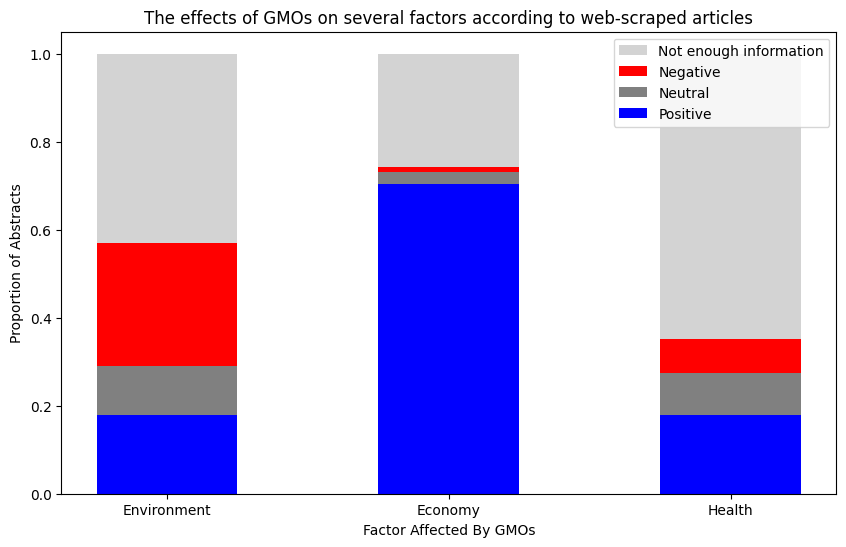

In [5]:
# transform data to our purposes
data = dict(pd.read_csv("data.csv"))
for k, v in data.items():
    data[k] = [*v]
    data_len = len(v)

# determine results
results = {
    metric: {
        opinion: data[metric].count(opinion) / data_len
        for opinion in ['g', 'b', 'n']
    }
    for metric in data.keys()
}

# plot graphs
stat_count = 3  # health, econ, env
x_size, y_size = 10, 6
fig = plt.figure(figsize=(x_size, y_size))
bar_width = x_size / stat_count / 2

# determines x-axis
x_axis = np.arange(0, x_size, x_size / stat_count)

# for stacking
goods = [v['g'] for v in results.values()]
mids = [v['g'] + v['n'] for v in results.values()]
bads = [v['g'] + v['n'] + v['b'] for v in results.values()]
not_enough = [1, 1, 1]

# plots bars
plt.bar(x_axis, not_enough, bar_width, color="lightgray", label="Not enough information")
plt.bar(x_axis, bads, bar_width, color="red", label="Negative")
plt.bar(x_axis, mids, bar_width, color="gray", label="Neutral")
plt.bar(x_axis, goods, bar_width, color="blue", label="Positive")

# labels
plt.xticks(x_axis, map(lambda x: x[0].upper() + x[1::], results.keys()), fontsize=10)    
plt.xlabel("Factor Affected By GMOs")
plt.ylabel("Proportion of Abstracts")
plt.title(f"The effects of GMOs on several factors according to web-scraped articles")

# shows figure
plt.legend(loc="best")
plt.savefig(f"result.png")
plt.show()